#Introducing optimization

In [1]:
!pip install nnfs

In [5]:
import numpy as np

In [7]:
# Common loss class
class Loss:

  # Calculates the data and regularizations losses given model output and
  # ground truth values
  def calculate(self, output, y):

    # Calculate sample losses
    sample_losses = self.forward(output, y)

    # Calculate mean loss
    data_loss = np.mean(sample_losses)

    # Return loss
    return data_loss


# Cross-entropy loss
class Loss_CategoricalCrossentropy(Loss):

  # Forward pass
  def forward(self, y_pred, y_true):

    # Number of samples in a batch
    samples = len(y_pred)

    # Clip data to prevent division by 0 when calculating log. We have to avoid
    # calculating log(0). Then, we clip all the output values from softmax between
    # 1e-7 and 1-1e-7.
    y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7)

    # Probabilities for target values - only if categorical labels
    # this is for sparse labels [0, 2, 5, 1], each value is a label
    if len(y_true.shape) == 1:
      correct_confidences = y_pred_clipped[range(samples), y_true]

    # for one hot encoded labels, we multiply each softmax output
    # by the label
    elif len(y_true.shape) == 2:
      correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)


    # Losses
    negative_log_likelihoods = -np.log(correct_confidences)

    return negative_log_likelihoods

# --------------------class layer dense----------------

class Layer_Dense:

  def __init__(self, n_inputs, n_neurons):
    """
    Initialise weights and biases
    random.randn returns a matrix with n_inputs x n_neurons shape
    it makes sense to create the weights matrix with inputs x neurons shape
    NUMBER OF WEIGHTS VALUES = NUMBER OF INPUTS X NUMBER OF NEURONS
    
    note that we define the shape as inputs X neurons and not neurons X inputs
    to avoid transposing every time we do a forward pass
    
        4 inputs, 3 neurons
        wij -> weight, i -> input value, j -> neuron 
        [w11, w12, w13]
        [w21, w22, w23]
        [w31, w32, w33]
        [w41, w42, w43]

        each column is already a vector of weights of each neuron for the input
    
    random.randn generates values from a Gaussian distribution with a mean of 0
    and a variance of 1, which mean that it'll generate random numbers, positive and
    negative [-1,1], centered at 0 and with the mean value close to 0.
    
    we multiply here by 0.01 because we want to initialise weights with non-zero values
    but these values have to be small because training updates will be smaller. 
    If weight values are very big, the training will last more time.
    
    """
    
    self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
    # ONE BIAS VALUE FOR EACH NEURON
    self.biases = np.zeros((1, n_neurons))


  # Forward pass
  def forward(self, inputs):
    # Calculate outputs values from inputs, weights and biases
    self.output = np.dot(inputs, self.weights) + self.biases

# --------------------------------------------------------
# ReLU activation class
class Activation_ReLU:

  # Forward pass
  def forward(self, inputs):
    # Calculate output values from input
    self.output = np.maximum(0, inputs)


# -------------------------------------------------------
# Softmax activation class
class Activation_Softmax:

  # Forward pass
  def forward(self, inputs):
    
    # Get unnormalized probabilities
    exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))

    # Normalize them for each sample
    probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)

    self.output = probabilities

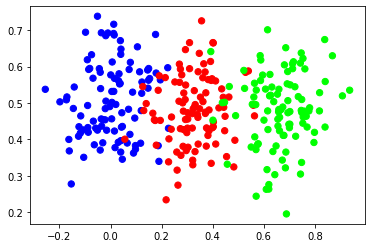

In [20]:
import matplotlib.pyplot as plt
import nnfs
from nnfs.datasets import vertical_data, spiral_data

nnfs.init()

X, y = vertical_data(samples=100, classes=3)

plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap='brg')
plt.show()

# Here we are testing if changing the weights randomly can help the neural network to achieve convergence

In [17]:
#create model
dense1 = Layer_Dense(2, 3)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(3, 3)
activation2 = Activation_Softmax()

#create loss function
loss_function = Loss_CategoricalCrossentropy()

#create some variables to track the best loss and the associated weights and biases
lowest_loss = 9999999
best_dense1_weights = dense1.weights.copy()
best_dense1_biases = dense1.biases.copy()
best_dense2_weights = dense2.weights.copy()
best_dense2_biases = dense2.biases.copy()

# we initialize weights to random in each epoch, and later we update the weights
# if the loss decreases.
for iteration in range(10000):

  #generate a new set of weights for iteration
  dense1.weights = 0.05 * np.random.randn(2, 3)
  dense1.biases = 0.05 * np.random.randn(1, 3)
  dense2.weights = 0.05 * np.random.randn(3, 3)
  dense2.biases = 0.05 * np.random.randn(1, 3)

  # perform a forward pass of the training data through this layer
  dense1.forward(X)
  activation1.forward(dense1.output)
  dense2.forward(activation1.output)
  activation2.forward(dense2.output)
  # calculating loss
  loss = loss_function.calculate(activation2.output, y)

  # calculate accuracy from output of activation2 and targets
  predictions = np.argmax(activation2.output, axis=1)
  accuracy = np.mean(predictions==y)

  # if loss is smaller - print print and save weights and biases aside
  if loss < lowest_loss:
    print('New set of weights found, iteration:', iteration,
            'loss:', loss, 'acc:', accuracy)
    
    best_dense1_weights = dense1.weights.copy()
    best_dense1_biases = dense1.biases.copy()
    best_dense2_weights = dense2.weights.copy()
    best_dense2_biases = dense2.biases.copy()
    lowest_loss = loss

New set of weights found, iteration: 0 loss: 1.0986564 acc: 0.3333333333333333
New set of weights found, iteration: 3 loss: 1.098138 acc: 0.3333333333333333
New set of weights found, iteration: 117 loss: 1.0980115 acc: 0.3333333333333333
New set of weights found, iteration: 124 loss: 1.0977516 acc: 0.6
New set of weights found, iteration: 165 loss: 1.0975711 acc: 0.3333333333333333
New set of weights found, iteration: 552 loss: 1.0974693 acc: 0.34
New set of weights found, iteration: 778 loss: 1.0968257 acc: 0.3333333333333333
New set of weights found, iteration: 4307 loss: 1.0965533 acc: 0.3333333333333333
New set of weights found, iteration: 4615 loss: 1.0964499 acc: 0.3333333333333333
New set of weights found, iteration: 9450 loss: 1.0964295 acc: 0.3333333333333333


# We can see that searching the weights randomly is not the proper way to do it.

Another option is to take a fraction of the weights and biases that produce the decrease in loss, instead of taking random values after decreasing the loss.

In [18]:
#create model
dense1 = Layer_Dense(2, 3)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(3, 3)
activation2 = Activation_Softmax()

#create loss function
loss_function = Loss_CategoricalCrossentropy()

#create some variables to track the best loss and the associated weights and biases
lowest_loss = 9999999
best_dense1_weights = dense1.weights.copy()
best_dense1_biases = dense1.biases.copy()
best_dense2_weights = dense2.weights.copy()
best_dense2_biases = dense2.biases.copy()

# we initialize weights to random in each epoch, and later we update the weights
# if the loss decreases.
for iteration in range(10000):

  #generate a new set of weights for iteration
  # HERE WE TAKE A FRACTION OF THE WEIGHTS
  dense1.weights += 0.05 * np.random.randn(2, 3)
  dense1.biases += 0.05 * np.random.randn(1, 3)
  dense2.weights += 0.05 * np.random.randn(3, 3)
  dense2.biases += 0.05 * np.random.randn(1, 3)

  # perform a forward pass of the training data through this layer
  dense1.forward(X)
  activation1.forward(dense1.output)
  dense2.forward(activation1.output)
  activation2.forward(dense2.output)
  # calculating loss
  loss = loss_function.calculate(activation2.output, y)

  # calculate accuracy from output of activation2 and targets
  predictions = np.argmax(activation2.output, axis=1)
  accuracy = np.mean(predictions==y)

  # if loss is smaller - print print and save weights and biases aside
  if loss < lowest_loss:
    print('New set of weights found, iteration:', iteration,
            'loss:', loss, 'acc:', accuracy)
    
    best_dense1_weights = dense1.weights.copy()
    best_dense1_biases = dense1.biases.copy()
    best_dense2_weights = dense2.weights.copy()
    best_dense2_biases = dense2.biases.copy()
    lowest_loss = loss

  else:
    dense1.weights = best_dense1_weights.copy()
    dense1.biases = best_dense1_biases.copy()
    dense2.weights = best_dense2_weights.copy()
    dense2.biases = best_dense2_biases.copy()

New set of weights found, iteration: 0 loss: 1.099457 acc: 0.3333333333333333
New set of weights found, iteration: 3 loss: 1.0976219 acc: 0.3333333333333333
New set of weights found, iteration: 4 loss: 1.0967989 acc: 0.3333333333333333
New set of weights found, iteration: 6 loss: 1.0936456 acc: 0.65
New set of weights found, iteration: 11 loss: 1.089228 acc: 0.3333333333333333
New set of weights found, iteration: 13 loss: 1.0857452 acc: 0.3333333333333333
New set of weights found, iteration: 22 loss: 1.0826465 acc: 0.3333333333333333
New set of weights found, iteration: 26 loss: 1.0765401 acc: 0.3333333333333333
New set of weights found, iteration: 30 loss: 1.0692414 acc: 0.6433333333333333
New set of weights found, iteration: 31 loss: 1.0649691 acc: 0.3333333333333333
New set of weights found, iteration: 36 loss: 1.0625923 acc: 0.34
New set of weights found, iteration: 37 loss: 1.0572853 acc: 0.36
New set of weights found, iteration: 38 loss: 1.0536734 acc: 0.36666666666666664
New set

We see here that for this easy problem, this approach is just fine. Let's see it for the spiral dataset.

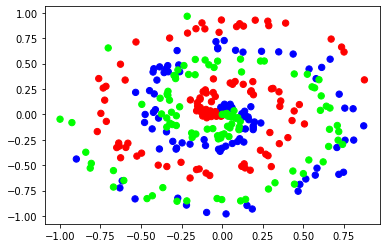

In [21]:
X, y = spiral_data(samples=100, classes=3)

plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap='brg')
plt.show()

In [22]:
#create model
dense1 = Layer_Dense(2, 3)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(3, 3)
activation2 = Activation_Softmax()

#create loss function
loss_function = Loss_CategoricalCrossentropy()

#create some variables to track the best loss and the associated weights and biases
lowest_loss = 9999999
best_dense1_weights = dense1.weights.copy()
best_dense1_biases = dense1.biases.copy()
best_dense2_weights = dense2.weights.copy()
best_dense2_biases = dense2.biases.copy()

# we initialize weights to random in each epoch, and later we update the weights
# if the loss decreases.
for iteration in range(10000):

  #generate a new set of weights for iteration
  # HERE WE TAKE A FRACTION OF THE WEIGHTS
  dense1.weights += 0.05 * np.random.randn(2, 3)
  dense1.biases += 0.05 * np.random.randn(1, 3)
  dense2.weights += 0.05 * np.random.randn(3, 3)
  dense2.biases += 0.05 * np.random.randn(1, 3)

  # perform a forward pass of the training data through this layer
  dense1.forward(X)
  activation1.forward(dense1.output)
  dense2.forward(activation1.output)
  activation2.forward(dense2.output)
  # calculating loss
  loss = loss_function.calculate(activation2.output, y)

  # calculate accuracy from output of activation2 and targets
  predictions = np.argmax(activation2.output, axis=1)
  accuracy = np.mean(predictions==y)

  # if loss is smaller - print print and save weights and biases aside
  if loss < lowest_loss:
    print('New set of weights found, iteration:', iteration,
            'loss:', loss, 'acc:', accuracy)
    
    best_dense1_weights = dense1.weights.copy()
    best_dense1_biases = dense1.biases.copy()
    best_dense2_weights = dense2.weights.copy()
    best_dense2_biases = dense2.biases.copy()
    lowest_loss = loss

  else:
    dense1.weights = best_dense1_weights.copy()
    dense1.biases = best_dense1_biases.copy()
    dense2.weights = best_dense2_weights.copy()
    dense2.biases = best_dense2_biases.copy()

New set of weights found, iteration: 0 loss: 1.0987747 acc: 0.3333333333333333
New set of weights found, iteration: 11 loss: 1.0984648 acc: 0.3333333333333333
New set of weights found, iteration: 15 loss: 1.0978488 acc: 0.33666666666666667
New set of weights found, iteration: 19 loss: 1.0977248 acc: 0.32666666666666666
New set of weights found, iteration: 33 loss: 1.0973078 acc: 0.38333333333333336
New set of weights found, iteration: 36 loss: 1.0972587 acc: 0.32666666666666666
New set of weights found, iteration: 37 loss: 1.0963988 acc: 0.36
New set of weights found, iteration: 40 loss: 1.0960455 acc: 0.36666666666666664
New set of weights found, iteration: 46 loss: 1.0947453 acc: 0.3433333333333333
New set of weights found, iteration: 49 loss: 1.0919566 acc: 0.36333333333333334
New set of weights found, iteration: 52 loss: 1.0903136 acc: 0.38
New set of weights found, iteration: 66 loss: 1.0897485 acc: 0.36333333333333334
New set of weights found, iteration: 67 loss: 1.0880351 acc: 0

# We see here that this training is not succesful. Later, we'll learn that the most probable reason for this is a local minimum of loss.